## Capstone Model Building

This is our inital passes at a few machine learning models designed to predict NHL player performance in an ESPN fantasy league. 

In [1]:
## set up packages and import saved flat file
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import seaborn as sb
import researchpy as rp
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
## import our now cleaned flat file, remind ourselves what it looks like

model_data = pd.read_csv('model_ready_data.csv')
model_data.head()

,Player,Team,Year,Position,Fantasy Points,GP,TOI,IPP,SHPer,iCF,...,Weight_(lbs),Draft_Round,Round_Pick,Overall_Draft_Position,drafted,Total Minutes Played,C,D,L,R
0,Aaron Ness,NYI,2014,D,25.80,20,275.25,100.0,4.35,48,...,184,2.0,10.0,40.0,1,295.88,0,1,0,0
1,Aaron Palushaj,CAR,2014,R,0.95,2,17.52,0.0,0.00,4,...,187,2.0,14.0,44.0,1,18.65,0,0,0,1
2,Aaron Rome,DAL,2014,D,27.50,25,301.20,10.0,0.00,36,...,220,4.0,8.0,104.0,1,327.20,0,1,0,0
3,Aaron Volpatti,WSH,2014,L,32.25,41,300.18,50.0,11.11,39,...,215,100.0,100.0,1000.0,0,301.87,0,0,1,0
4,Adam Almquist,DET,2014,D,3.45,2,31.52,50.0,50.00,3,...,174,7.0,29.0,210.0,1,34.43,0,1,0,0


In [3]:
# we need to reset the index and split into target and features 
model_data.set_index(keys=['Player','Team','Year','Position'],inplace=True)
Target = model_data.iloc[:,0].values  
features = model_data.iloc[:, 1:].values 
X_train, X_test, y_train, y_test = train_test_split(features, Target, test_size=0.2, random_state=0)  

Initially we'll start with a random forest regressor

In [4]:
## fitting without parameter tuning
regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
regressor.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Making intial predictions and charting performance

In [5]:
y_pred = regressor.predict(X_test)  
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('Regreessor Score:',RandomForestRegressor.score(regressor,X_test,  y_test))

Mean Absolute Error: 11.753717660292464
Mean Squared Error: 295.7487059898763
Root Mean Squared Error: 17.19734589958219
Regreessor Score: 0.9514555313337327


Examining the features

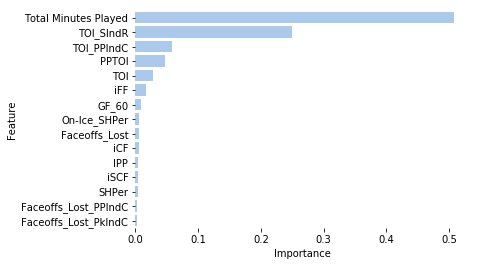

In [6]:
feature_import= list(zip(regressor.feature_importances_, model_data.columns[1:]))
feature_import = pd.DataFrame(feature_import, columns = ['Importance', 'Feature'])
top_features = feature_import.sort_values(by='Importance', ascending=False)[0:15]
# quick plot of values
sb.set_color_codes("pastel")
sb.barplot(x='Importance', y="Feature", data=top_features, color="b")
sb.despine(left=True, bottom=True)

Looking at features scores it's interesting that time again holds a lot of import. What I dislike here is that's not really something that we can then use as predictive value since that's a coaching decision, not a player skill.

Let's try some grid searching to see where we can find some improvements.

In [7]:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


param_grid = {"max_depth": [10, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              'n_estimators':[20,50,100],
              "bootstrap": [True, False]}

# run grid search
grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5)
start = time.gmtime()
grid_search.fit(X_train,  y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(grid_search.cv_results_['params'])))
grid_search.best_params_

GridSearchCV took 184.00 seconds for 108 candidate parameter settings.


{'bootstrap': False,
 'max_depth': None,
 'max_features': 10,
 'min_samples_split': 2,
 'n_estimators': 100}

In [8]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test) 

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('Regressor Score:',RandomForestRegressor.score(best_grid,X_test,  y_test))

Mean Absolute Error: 11.198483689538806
Mean Squared Error: 264.4461418239595
Root Mean Squared Error: 16.261800079448754
Regressor Score: 0.9565935634351417


The grid search did improve some but not a ton accros the board, other than in MSE, which makes sense as that's the metric it's scoring on.

| Metric      | Original          | Grid Search  | 
| ------------- |:-------------:| -----:| 
| Mean Absolute Error:    |  11.75 | 11.2 | 
| Mean Squared Error:    |  295.75 | 264.45 | 
| Root Mean Squared Error:     |  17.2 | 16.26 | 
| Regressor Score:    |  0.95 | 0.96 | 


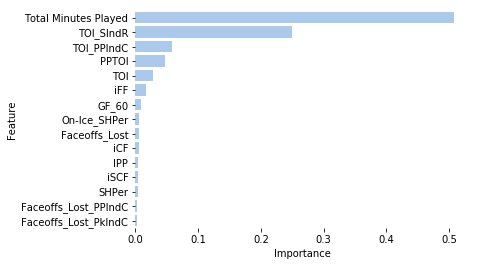

In [9]:
## checking how feature importance has changed
feature_import= list(zip(best_grid.feature_importances_, model_data.columns[1:]))
feature_import = pd.DataFrame(feature_import, columns = ['Importance', 'Feature'])
top_features_grid = feature_import.sort_values(by='Importance', ascending=False)[0:15]
# quick plot of values
sb.set_color_codes("pastel")
sb.barplot(x='Importance', y="Feature", data=top_features, color="b")
sb.despine(left=True, bottom=True)

In [10]:
## for fun I decided to re run the above using just the top 15 features, to see if triming 
## the options would reduce noise even further
feature_list = top_features_grid.Feature.unique()
trimmed_features = model_data.loc[:,feature_list].values 
trimmed_X_train, trimmed_X_test, trimmed_y_train, trimmed_y_test = train_test_split(trimmed_features, Target, test_size=0.2, random_state=0) 

In [11]:
trimmed_regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
trimmed_regressor.fit(trimmed_X_train, trimmed_y_train)
# run grid search
grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5)
start = time.gmtime()
grid_search.fit(trimmed_X_train,  trimmed_y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(grid_search.cv_results_['params'])))
grid_search.best_params_

GridSearchCV took 202.00 seconds for 108 candidate parameter settings.


{'bootstrap': False,
 'max_depth': None,
 'max_features': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [12]:
best_grid = grid_search.best_estimator_
trimmed_y_pred = best_grid.predict(trimmed_X_test) 

print('Mean Absolute Error:', metrics.mean_absolute_error(trimmed_y_test, trimmed_y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(trimmed_y_test, trimmed_y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(trimmed_y_test, trimmed_y_pred))) 
print('Regressor Score:',RandomForestRegressor.score(best_grid,trimmed_X_test,  trimmed_y_test))

Mean Absolute Error: 13.700202715955148
Mean Squared Error: 400.8060463075549
Root Mean Squared Error: 20.020141016175558
Regressor Score: 0.9342113214287618


So that backfired in that it significantly increased the errors, especially on MSE, which is pretty significant.

Let's move on and try some more classic models

In [17]:
## linear regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()  
lin_reg.fit(X_train, y_train) 
print(lin_reg.intercept_)

87.15018870456066


In [27]:
y_pred = lin_reg.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df[1:20]

,Actual,Predicted
1,14.35,16.345904
2,233.65,199.122168
3,141.50,153.884523
4,185.85,200.685100
5,150.95,164.722377
6,135.25,130.762171
7,75.00,91.965385
8,158.80,176.621316
9,108.85,109.707626
10,120.45,144.194733


This is sort of goofy in that there are negative values, which I'm sure there should be some way to prevent in the code. From a glance they're low value players anyway, but it's still seems less than ideal. 

In [29]:
## looking at metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('Regressor Score:',LinearRegression.score(lin_reg,X_test,  y_test))

Mean Absolute Error: 12.528944160798359
Mean Squared Error: 280.0456966076776
Root Mean Squared Error: 16.73456592229621
Regressor Score: 0.9540330379516191


Well this is a close but no cigar type item. The RMSE was about the same, but in every other area 

| Metric      | Linear Regression         | Grid Search  | 
| ------------- |:-------------:| -----:| 
| Mean Absolute Error:    |  12.53 | 11.2 | 
| Mean Squared Error:    |  280.05 | 264.45 | 
| Root Mean Squared Error:     |  16.73 | 16.26 | 
| Regressor Score:    |  0.95 | 0.96 | 

In [1]:
## let's try some gradient decent

from sklearn.linear_model import SGDRegressor

stgd = SGDRegressor( tol=1e-3)
stgd.fit(X_train, y_train)
sty_pred = stgd.predict(X_test)


NameError: name 'X_train' is not defined

In [33]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, sty_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, sty_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, sty_pred))) 
print('Regressor Score:',LinearRegression.score(stgd,X_test,  y_test))

Mean Absolute Error: 276910852823952.53
Mean Squared Error: 1.669157145384065e+29
Root Mean Squared Error: 408553196705651.2
Regressor Score: -2.7397701190938288e+25


In [34]:
sty_pred

array([-6.60765116e+14, -2.08198284e+14,  1.10224856e+13, -2.61071896e+14,
       -4.77827137e+13, -4.01338868e+13, -3.00834702e+14, -1.56067766e+14,
       -1.45407906e+14, -5.80910399e+14, -6.55287056e+13, -1.14148890e+14,
       -1.69026627e+14, -4.56205061e+14,  8.08620516e+14, -3.81052867e+14,
       -4.14324986e+14, -8.75458872e+14, -1.15052447e+14, -7.81281159e+14,
        1.18805243e+14, -6.42274468e+13, -6.87274746e+14, -2.10227519e+13,
       -6.08861669e+13,  1.44385328e+14, -1.37886560e+14,  7.72519351e+14,
       -2.81795424e+14,  1.40424364e+14, -2.27862424e+14, -1.48783893e+14,
        1.93832433e+14, -2.29481785e+14, -1.57156364e+14, -9.81529622e+12,
        1.86757447e+14, -6.16286238e+14,  6.11488464e+14, -4.77888873e+14,
       -1.22330551e+14,  3.78790393e+13, -7.54584266e+14, -1.69758409e+14,
       -1.90700555e+14,  2.68985326e+14, -7.48750357e+14,  5.56731855e+14,
       -7.33362570e+14,  4.88919653e+14, -2.17316957e+14, -1.05107595e+14,
        5.40181163e+14, -